# TASK 3 - DESCRIPTION

Maximum Independent Set (MIS) is a combinatorial optimization problem that is naturally suited to implementation on a Rydberg atom quantum computer. Specifically, the Rydberg blockade implies that two atoms cannot be both excited to the Rydberg state  if they are close to each other. In MIS, the independent set constraint means that two vertices on a graph cannot be both in the independent set when they are connected by an edge. Thus, one can consider atoms in the Rydberg state as vertices in an independent set. Read more about the MIS problem here.

Following the Bloqade tutorial script, solve the  diagonal-connected unit-disk grid graphs (DUGG) problems using the adiabatic approach. How large of an array can Bloqade solve? Attempt to solve for larger square DUGGs using your tensor network approach. Try different pulse parameterization and compare which is better, and explore how smoothing affects the performance

In [1]:
using Graphs
using Bloqade
using Compose
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

In [2]:
# Blocade radius
r_b = 5.72

# Total duration of pulses
t = 1.0

# Rabi Frequency
omega = 2 * π * 862690 / r_b^6

# Detuning amplitude
delta = 2π * 15.0

# Square side
n = 5

5

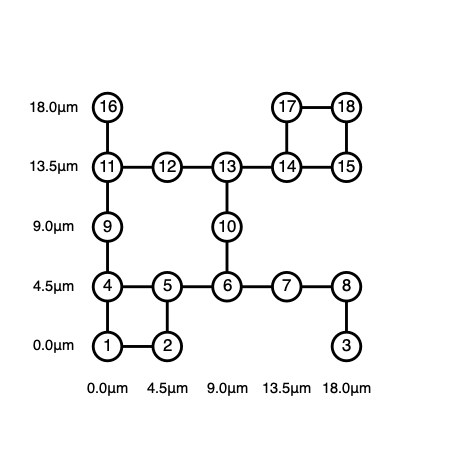

In [3]:
# Generate DUGG
Random.seed!(43)
atom_coordinate = generate_sites(SquareLattice(), n, n; scale = 4.5) |> random_dropout(0.3)
Bloqade.plot(atom_coordinate, blockade_radius = r_b)

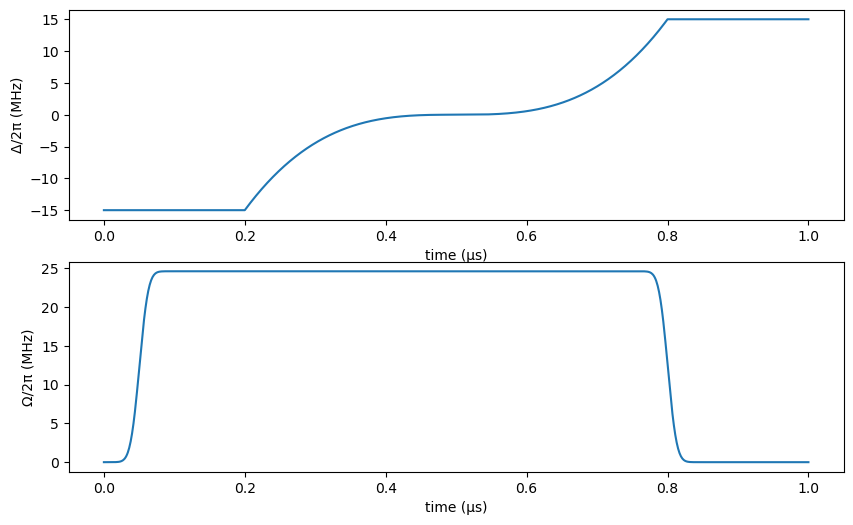

In [4]:
# Detuning waveform
d_change = 0.6

A = delta / ((d_change * t) / 2)^3
delta_t = Waveform(tt -> A * (tt - (d_change * t)/ 2)^3, duration=d_change * t)    # Cubic part of waveform
delta_t = append(constant(duration=(1 - d_change) / 2 * t, value=-delta), delta_t)
delta_t = append(delta_t, constant(duration=(1 - d_change) / 2 * t, value=delta))


# Omega waveform
omega_t = piecewise_constant(clocks=[0.0, 0.05 * t, t * ((1 + d_change) / 2), t], values=[0.0, omega, 0.0])
omega_t = smooth(omega_t; kernel_radius=0.01 * t)

# Plotting waveforms
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10, 6))
Bloqade.plot!(ax1, delta_t)
ax1.set_ylabel("Δ/2π (MHz)")
Bloqade.plot!(ax2, omega_t)
ax2.set_ylabel("Ω/2π (MHz)")
fig

In [5]:
# Creating blockade subspace, Hamiltonian and emulation 
subspace = blockade_subspace(atom_coordinate, r_b - 0.2)
reg = zero_state(subspace)
h = rydberg_h(atom_coordinate; Ω = omega_t, Δ = delta_t)
prob = SchrodingerProblem(reg, t, h)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: SubspaceArrayReg{2, ComplexF64, Vector{ComplexF64}, Subspace{Vector{Int64}}}
    storage size: 40 bytes

  time span (μs): (0.0, 1.0)

  equation: 
    storage size: 1.195 MiB
    expression:
nqubits: 18
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


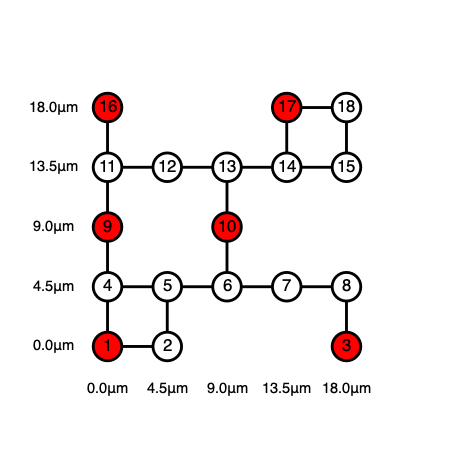

In [6]:
# Plotting MIS solution
best_bit_strings = most_probable(prob.reg, 15)
Bloqade.plot(atom_coordinate, blockade_radius = r_b;
    colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

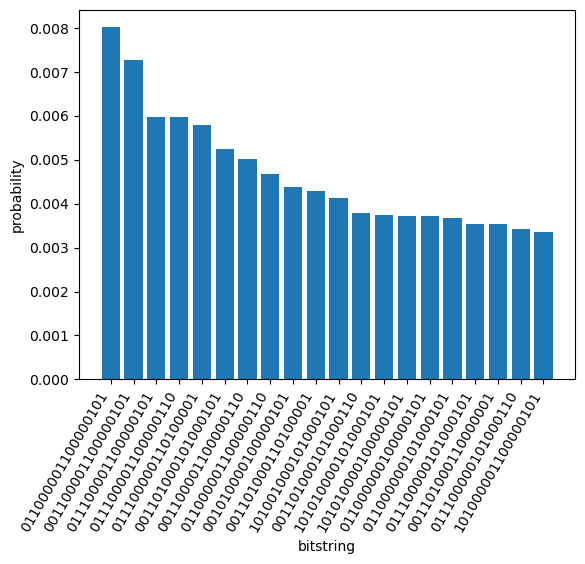

In [7]:
# Plotting bitstring histogram
bitstring_hist(prob.reg; nlargest = 20)

# Variational adjustment of detuning protocol

In [8]:
# Loss function for detuning waveform
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}

    delta_tt = smooth(
        piecewise_linear(
            clocks = [0.0, 0.1 * t, 0.3 * t, 0.5 * t, 0.7 * t, 0.9 * t, t],
            values = T[-delta, -delta, delta * x[1], delta * x[2], delta * x[3], delta, delta],
        );
        kernel_radius = 0.02,
    )
    
    hamiltonian = rydberg_h(atoms; Ω = omega_t, Δ = delta_tt)
    subspace = blockade_subspace(atoms, r_b - 0.2)
    prob = SchrodingerProblem(zero_state(subspace), t, hamiltonian)
    emulate!(prob)
    println("Value of cost function:", -rydberg_density_sum(prob.reg))
    return -rydberg_density_sum(prob.reg), prob.reg, delta_tt
end

loss_piecewise_constant (generic function with 1 method)

Value of cost function:-5.29322641572151
Value of cost function:-5.390304182014224
Value of cost function:-5.430003612501759
Value of cost function:-5.949287748359664
Value of cost function:-5.696410865231341
Value of cost function:-5.964031100481945
Value of cost function:-6.1856899280193485
Value of cost function:-6.384758230460277
Value of cost function:-6.6984605013146234
Value of cost function:-6.709570290808086
Value of cost function:-7.173808039447263
Value of cost function:-7.359923591844224
Value of cost function:-7.632422703720343
Value of cost function:-7.981255745836414
Value of cost function:-8.401799056335191
Value of cost function:-8.462578504935669
Value of cost function:-8.598885245159504
Value of cost function:-8.9849357926407
Value of cost function:-9.123633480211064
Value of cost function:-9.107124886923764
Value of cost function:-9.191062988738578
Value of cost function:-9.081385978402114
Value of cost function:-9.030749618945228
Value of cost function:-9.139920665

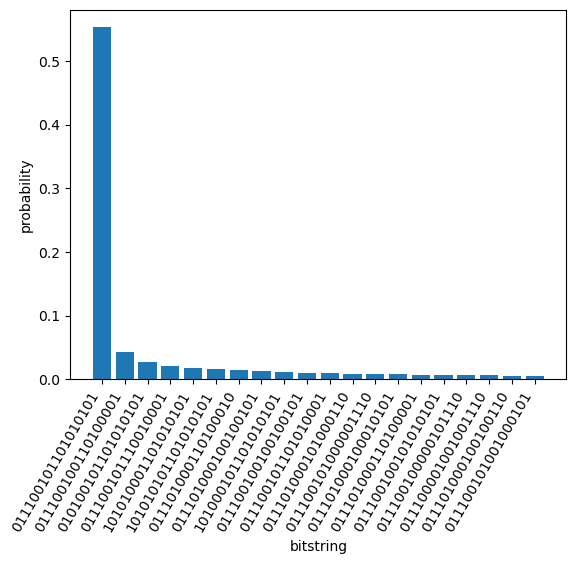

In [9]:
# Optimization of detuning waveform
x_0 = [0.35, 0.6, 0.85]
optresult = Optim.optimize(x -> loss_piecewise_constant(atom_coordinate, x)[1], x_0)

rydberg_density_final, reg1_final, waveform = loss_piecewise_constant(atom_coordinate, optresult.minimizer)
bitstring_hist(reg1_final; nlargest = 20)

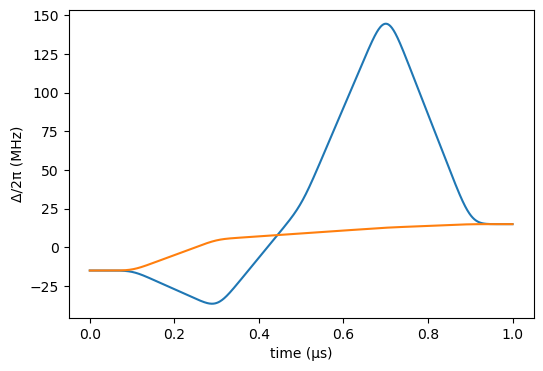

In [10]:
# Optimized waveform compare to start

delta_0 = smooth(
    piecewise_linear(
        clocks = [0.0, 0.1 * t, 0.3 * t, 0.5 * t, 0.7 * t, 0.9 * t, t],
        values = [-delta, -delta, delta * x_0[1], delta * x_0[2], delta * x_0[3], delta, delta],
    );
    kernel_radius = 0.02,
)
    
fig, ax1 = plt.subplots(ncols = 1, figsize = (6, 4))
Bloqade.plot!(ax1, waveform)
Bloqade.plot!(ax1, delta_0)
ax1.set_ylabel("Δ/2π (MHz)")
fig

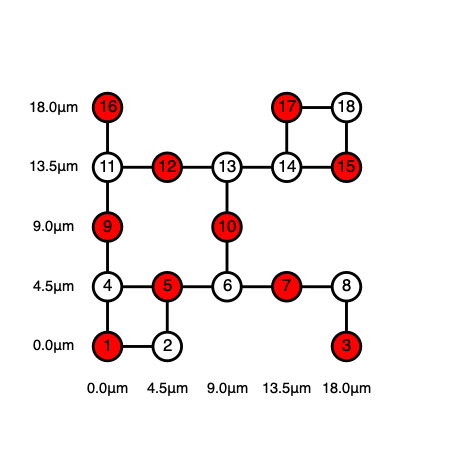

In [11]:
# Plotting MIS solution
best_bit_strings = most_probable(reg1_final, 15)
Bloqade.plot(atom_coordinate, blockade_radius = r_b;
    colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])